In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphicsb

pd.set_option('display.max_rows', None)

---
### Importing data

In [3]:
allData = pd.DataFrame()

# Adding initial condition
initialData = pd.read_excel('data/Injection Molding Data.xlsx', sheet_name = 'Initial')
allData = allData.append(initialData, ignore_index=True)

# Adding speed increase condition
speedIncData = pd.read_excel('data/Injection Molding Data.xlsx', sheet_name = 'Speed Increase')
allData = allData.append(speedIncData, ignore_index=True)

# Adding speed decrease condition
speedDecData = pd.read_excel('data/Injection Molding Data.xlsx', sheet_name = 'Speed Decrease')
allData = allData.append(speedDecData, ignore_index=True)

# Adding position increase condition
posIncData = pd.read_excel('data/Injection Molding Data.xlsx', sheet_name = 'Position Increase')
allData = allData.append(posIncData, ignore_index=True)

# Adding position decrease condition
posDecData = pd.read_excel('data/Injection Molding Data.xlsx', sheet_name = 'Position Decrease')
allData = allData.append(posDecData, ignore_index=True)

allData.head()

,CYCLE TIME,INJECT TIME,INJECT POSITION,MAX PRESSURE,METER TIME,CHANGE PRESSURE,CHANGE POSITION,CONDITION
0,50.07,1.62,2.60,121.5,8.78,891,12.99,Initial
1,35.06,1.62,2.55,124.0,9.05,896,12.99,Initial
2,34.02,1.62,2.39,121.7,8.86,898,13.00,Initial
3,0.00,1.62,2.32,122.1,0.00,894,12.99,Initial
4,38.88,1.62,2.68,124.2,8.79,903,12.99,Initial


---
### Viewing boxplot of all variables

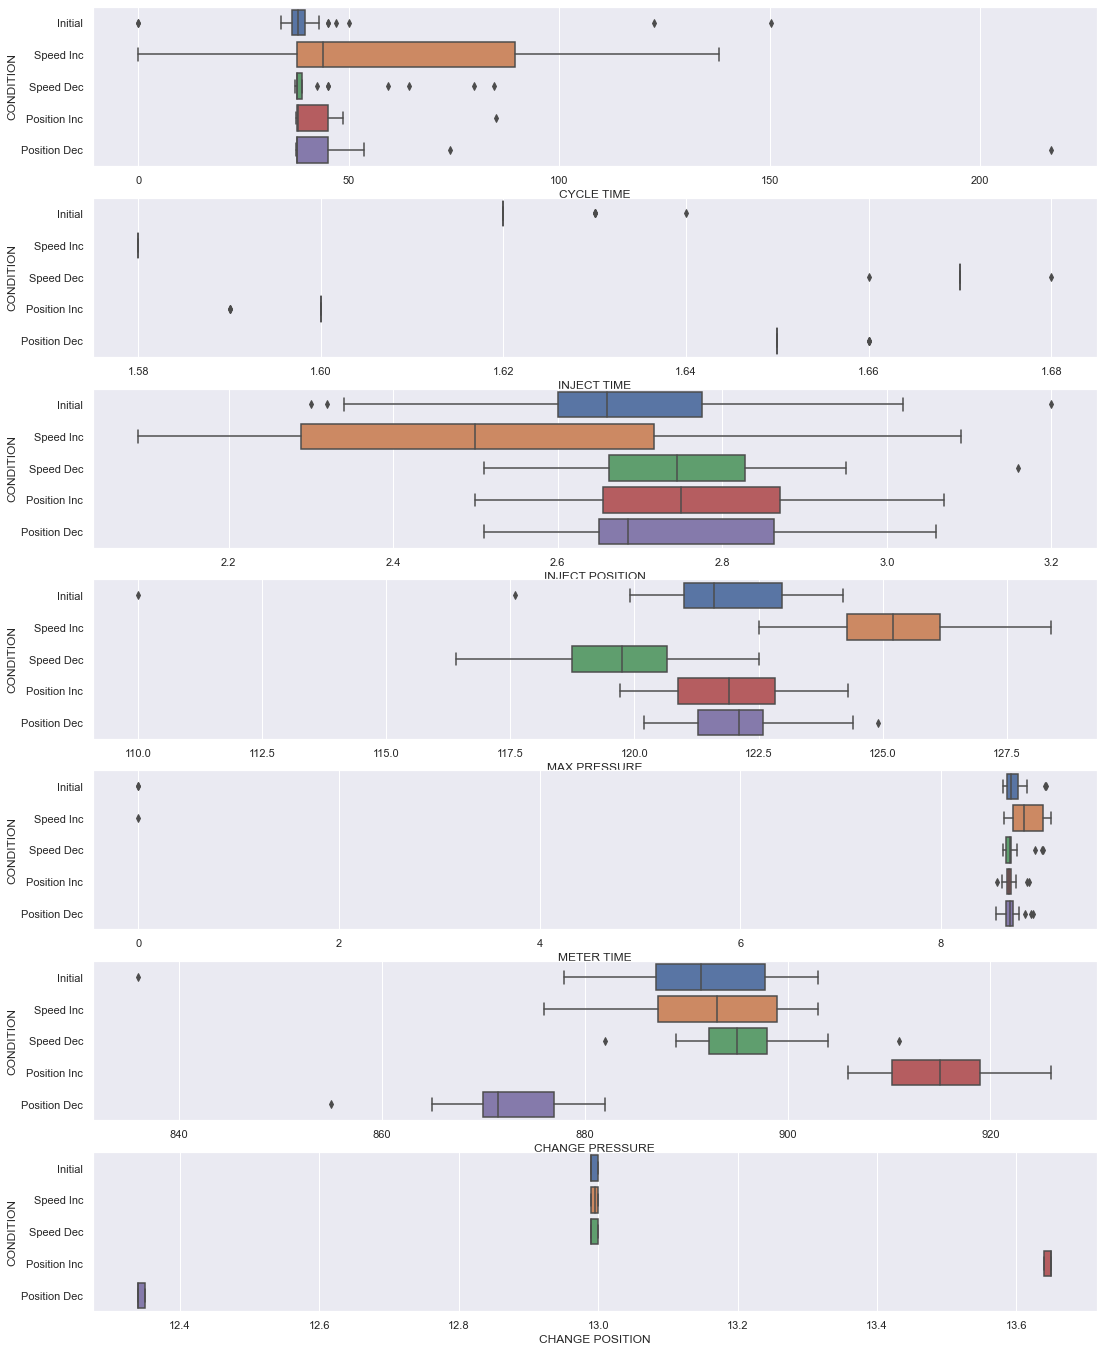

In [4]:
# Extract Response and Predictors
y = pd.DataFrame(allData["CONDITION"].astype('category'))
X = pd.DataFrame(allData[["CYCLE TIME", "INJECT TIME", "INJECT POSITION", "MAX PRESSURE", "METER TIME", "CHANGE PRESSURE", "CHANGE POSITION"]])

# Relationship between Response and the Predictors
trainDF = pd.concat([y, X.reindex(index=y.index)], sort = False, axis = 1)

f, axes = plt.subplots(7, 1, figsize=(18, 24))

conditionOrder = ["Initial", "Speed Inc", "Speed Dec", "Position Inc", "Position Dec"]
count = 0
for var in X:
    sb.boxplot(x = var, y = "CONDITION", data = trainDF, orient = "h", ax = axes[count], order = conditionOrder)
    count += 1

---
### Fitting of data into Decision Tree

Classification Accuracy 	: 1.0



<AxesSubplot:>

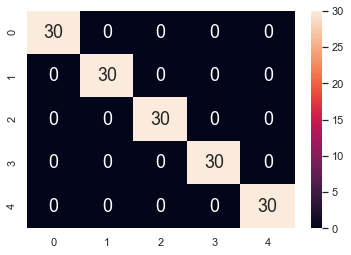

In [5]:
# Import Decision Tree Classifier model from Scikit-Learn
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

# Decision Tree using Train Data
dectree = DecisionTreeClassifier()
dectree.fit(X, y)

# Predict Response corresponding to Predictors
y_pred = dectree.predict(X)

# Check the Goodness of Fit
print("Classification Accuracy \t:", dectree.score(X, y))
print()

# Plot the Confusion Matrix for Train and Test
sb.heatmap(confusion_matrix(y, y_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})





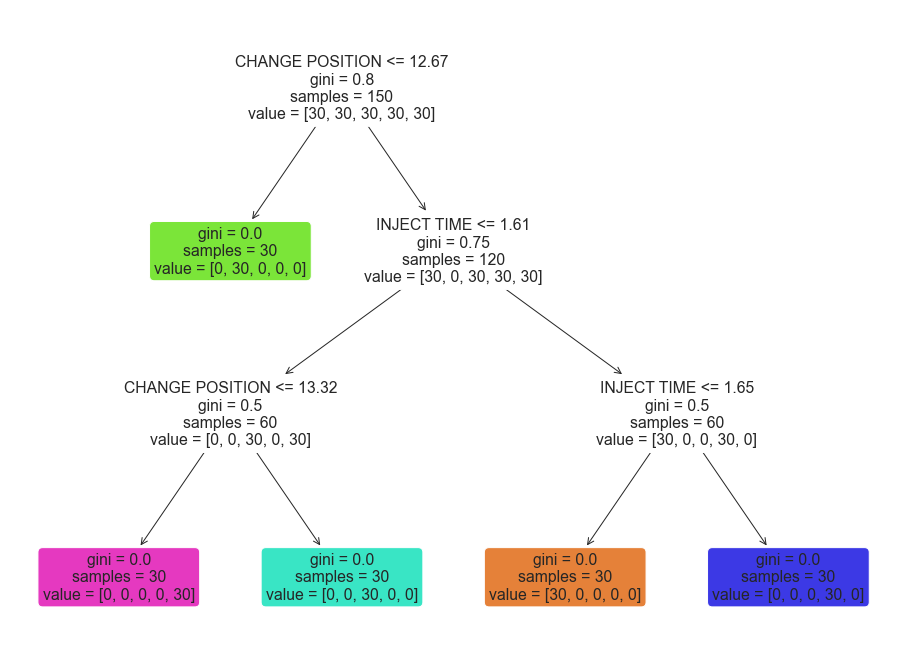

In [6]:
# Plot the Decision Tree model
from sklearn.tree import plot_tree
f, axes = plt.subplots(1, 1, figsize=(16, 12))

plot_tree(dectree, filled=True, rounded = True, 
          feature_names=X.columns)
plt.show()

---
### Importing test data

In [16]:
# Adding initial condition
testData = pd.read_excel('data/Injection Molding Data.xlsx', sheet_name = 'Testing')

# testData = testData.drop(columns="CONDITION")
testData.head()

,CYCLE TIME,INJECT TIME,INJECT POSITION,MAX PRESSURE,METER TIME,CHANGE PRESSURE,CHANGE POSITION,CONDITION
0,37.53,1.62,2.61,122.5,8.75,898,13.00,Initial
1,39.93,1.62,2.66,122.9,8.71,901,13.00,Initial
2,33.85,1.62,3.20,122.7,8.70,895,12.99,Initial
3,150.36,1.62,2.30,123.4,9.04,898,12.99,Initial
4,34.21,1.62,2.72,117.6,8.80,880,13.00,Initial


---
### Grouping of test data

In [21]:
import statistics

def createPredictedDF(groupSize):
    start = 1
    end = groupSize

    meanDF = pd.DataFrame()

    try:
        while True:
            dataGroupCycleTime = []
            dataGroupInjectTime = []
            dataGroupInjectPosition = []
            dataGroupMaxPressure = []
            dataGroupMeterTime = []
            dataGroupChangePressure = []
            dataGroupChangePosition = []

            for i in range(start - 1, end):
                dataGroupCycleTime.append(testData["CYCLE TIME"].iloc[i])
                dataGroupInjectTime.append(testData["INJECT TIME"].iloc[i])
                dataGroupInjectPosition.append(testData["INJECT POSITION"].iloc[i])
                dataGroupMaxPressure.append(testData["MAX PRESSURE"].iloc[i])
                dataGroupMeterTime.append(testData["METER TIME"].iloc[i])
                dataGroupChangePressure.append(testData["CHANGE PRESSURE"].iloc[i])
                dataGroupChangePosition.append(testData["CHANGE POSITION"].iloc[i])


            meanCycleTime = statistics.mean(dataGroupCycleTime)
            meanInjectTime = statistics.mean(dataGroupInjectTime)
            meanInjectPosition = statistics.mean(dataGroupInjectPosition)
            meanMaxPressure = statistics.mean(dataGroupMaxPressure)
            meanMeterTime = statistics.mean(dataGroupMeterTime)
            meanChangePressure = statistics.mean(dataGroupChangePressure)
            meanChangePosition = statistics.mean(dataGroupChangePosition)

            newRow = [{ 'MEAN CYCLE TIME': meanCycleTime, 
                        'MEAN INJECT TIME': meanInjectTime, 
                        'MEAN INJECT POSITION': meanInjectPosition, 
                        'MEAN MAX PRESSURE': meanMaxPressure, 
                        'MEAN METER TIME': meanMeterTime, 
                        'MEAN CHANGE PRESSURE': meanChangePressure, 
                        'MEAN CHANGE POSITION': meanChangePosition}]

            meanDF = meanDF.append(newRow, ignore_index=True)

            start += 1
            end += 1

    except IndexError:
        pass


    # Predict response for the points
    y_pred = dectree.predict(meanDF)

    currentCondition = testData["CONDITION"][meanDF.index + groupSize - 1].to_numpy()
    currentCondition = pd.DataFrame(currentCondition, columns = ["LATEST CONDITION"], index = meanDF.index)
    combinedDF = pd.concat([meanDF, currentCondition], axis = 1)

    # Concatenate with the given data
    y_pred = pd.DataFrame(y_pred, columns = ["PREDICTED CONDITION"], index = meanDF.index)
    combinedDF = pd.concat([combinedDF, y_pred], axis = 1)
    return combinedDF

In [23]:
# Calculating accuracy for different group sizes
for groupNo in range(4):
    rowNo = 0
    correct = 0
    groupSize = (groupNo+1) * 5

    predictedDF = createPredictedDF(groupSize)
    while rowNo < predictedDF.shape[0]:
        if predictedDF['LATEST CONDITION'].iloc[rowNo] == predictedDF['PREDICTED CONDITION'].iloc[rowNo]:
            correct += 1
        rowNo += 1

    accuracy = correct/rowNo
    print("Accuracy for group size {0}: {1:%}".format(groupSize, accuracy))

Accuracy for group size 5: 90.909091%
Accuracy for group size 10: 78.362573%
Accuracy for group size 15: 65.662651%
Accuracy for group size 20: 52.795031%


---
### Group size of 5 have highest accuracy. Displaying table for groupsize 5...

In [22]:
createPredictedDF(5)

,MEAN CYCLE TIME,MEAN INJECT TIME,MEAN INJECT POSITION,MEAN MAX PRESSURE,MEAN METER TIME,MEAN CHANGE PRESSURE,MEAN CHANGE POSITION,LATEST CONDITION,PREDICTED CONDITION
0,59.176,1.620,2.698,121.82,8.800,894,12.996,Initial,Initial
1,51.670,1.620,2.774,119.32,7.050,882,12.994,Initial,Initial
2,51.244,1.620,2.710,118.76,7.056,877,12.994,Initial,Initial
3,51.982,1.620,2.584,118.44,7.062,876,12.994,Initial,Initial
4,29.500,1.620,2.646,117.86,6.986,873,12.994,Initial,Initial
5,30.202,1.622,2.634,118.54,6.958,874,12.992,Initial,Initial
6,39.206,1.622,2.588,121.26,8.702,885,12.994,Initial,Initial
7,39.422,1.624,2.646,122.02,8.686,889,12.994,Initial,Initial
8,39.082,1.624,2.710,122.04,8.670,889,12.994,Initial,Initial
9,40.874,1.624,2.708,122.24,8.702,889,12.996,Initial,Initial
